# Oracle SAT solver


#### Satisfy to following 3-SAT
(1)\
(x ∨ y) ∧ ¬y ∧ (z ∨ ¬z)

### In QC, we know how to implement the AND operator -> (Multi-Controlled X gate)
### What about the OR?

##### Recalling De Morgan
¬(a ∧ b) = ¬a ∨ ¬b \
¬(a ∨ b) = ¬a ∧ ¬b

#### Let us rewrite (1)
(x ∨ y) ∧ ¬y ∧ (z ∨ ¬z) = \
¬(¬x ∧ ¬y) ∧ ¬y 

1) Note that (z ∨ ¬z) is always true, thus we can remove it. 

2) Now the SAT instance is expressed in terms of only AND -> happy :)

The solutions are 2: 001, 101 (order: zyx)

In [12]:
import qiskit
import numpy as np
import random
import math
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, BasicAer, Aer
from qiskit.extensions import Initialize, UnitaryGate
from qiskit.visualization import plot_histogram, plot_bloch_multivector, plot_state_city

from qiskit.circuit.library import CPhaseGate,CU1Gate, CRXGate, MCXGate

from numpy import pi

## Diffuser

In [13]:
def get_diffuser(n_var):
    qvar = QuantumRegister(n_var)
    qtarget = QuantumRegister(1)
    diffuser = QuantumCircuit(qvar, qtarget, name='diffuser')
    diffuser.h(qvar)
    diffuser.x(qvar)
    diffuser.append(MCXGate(len(qvar)), qvar[0:]+qtarget[0:])
    diffuser.x(qvar)
    diffuser.h(qvar)
    return diffuser

## Oracle

In [14]:
def get_oracle(n_var):
    oq_n = QuantumRegister(n, 'x')
    oq_w = QuantumRegister(m, 'w')
    oq_checker = QuantumRegister(1, 'checker')
    oracle = QuantumCircuit(oq_n, oq_w, oq_checker, name='oracle')
    
    #clause: (¬x ∧ ¬y)
    n_variables_clause_1 = 2
    oracle.x(oq_n[0])
    oracle.x(oq_n[1])
    oracle.append(MCXGate(n_variables_clause_1), [oq_n[0], oq_n[1], oq_w[0]])
    oracle.x(oq_n[0])
    oracle.x(oq_n[1])
    
    #clause: ¬y
    n_variables_clause_2 = 1
    oracle.x(oq_n[1])
    oracle.append(MCXGate(n_variables_clause_2), [oq_n[1], oq_w[1]])
    oracle.x(oq_n[1])

    #clause: ¬(¬x ∧ ¬y) ∧ ¬y
    oracle.barrier()
    oracle.x(oq_w[0])
    oracle.append(MCXGate(len(oq_w)), oq_w[0:]+oq_checker[0:])
    oracle.x(oq_w[0])
    
    
    #uncomputation
    oracle.barrier()
    n_variables_clause_2 = 1
    oracle.x(oq_n[1])
    oracle.append(MCXGate(n_variables_clause_2), [oq_n[1], oq_w[1]])
    oracle.x(oq_n[1])


    oracle.barrier()
    oracle.x(oq_n[0])
    oracle.x(oq_n[1])
    oracle.append(MCXGate(n_variables_clause_1), [oq_n[0], oq_n[1], oq_w[0]])
    oracle.x(oq_n[0])
    oracle.x(oq_n[1])

    return oracle

# Quantum Circuit for the SAT instance

In [15]:
q_n = QuantumRegister(n, 'x')
q_w = QuantumRegister(m, 'w') #working qubits: for each clauses, 1 working qubit storing the result
q_checker = QuantumRegister(1, 'checker')

c_n = ClassicalRegister(len(q_n), 'res')

sat_solver = QuantumCircuit(q_n, q_w, q_checker, c_n)



## Step 1: Generate all the possible assignments for the boolean formula 

In [16]:
sat_solver.h(q_n) 

## Step 2 - 3: Apply Oracle and Diffuser

In [17]:
n_solutions = 2 #known a priori somehow
iterations = math.floor(math.pi/4 * math.sqrt(2**len(q_n)/n_solutions))

for i in range(iterations):
    sat_solver.append(get_oracle(len(q_n)), q_n[0:]+q_w[0:]+[q_checker])
    sat_solver.append(get_diffuser(len(q_n)), q_n[0:]+[q_checker])

### Oracle Circuit

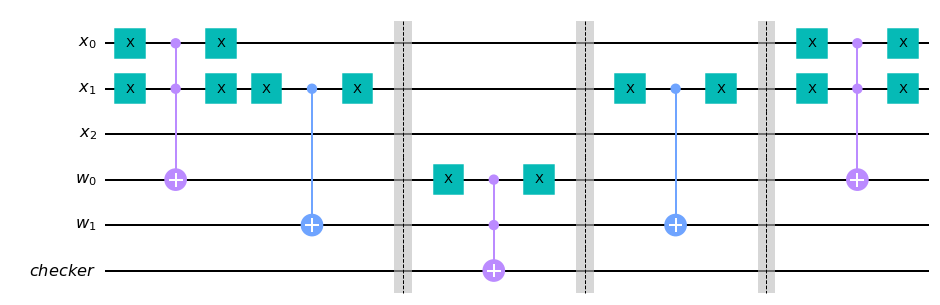

In [18]:
get_oracle(len(q_n)).draw(output='mpl')

### Diffuser Circuit

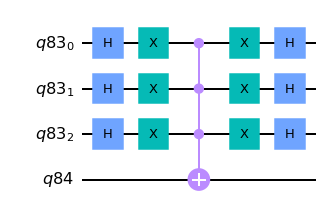

In [19]:
get_diffuser(len(q_n)).draw(output='mpl')

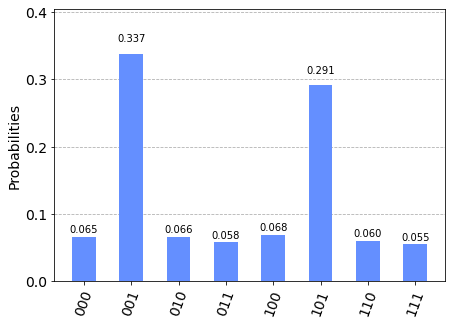

In [20]:
sat_solver.measure(q_n[0],c_n[0])
sat_solver.measure(q_n[1],c_n[1])
sat_solver.measure(q_n[2],c_n[2])

sat_solver.draw('mpl')

simulator = Aer.get_backend('qasm_simulator')
result = execute(sat_solver, simulator, shots=4096).result()
counts = result.get_counts(sat_solver)
plot_histogram(counts)